In [1]:
import numpy as np
np.random.seed(39)
import tqdm
import mikutoolkit as miku
from matplotlib import pyplot as plt
plt.style.use("solarized-light")
#plt.xkcd()

あなたもミクと創ろう、世界を繋ごう。


# Numerical Analysis: Poly Interpolation (for Instance)

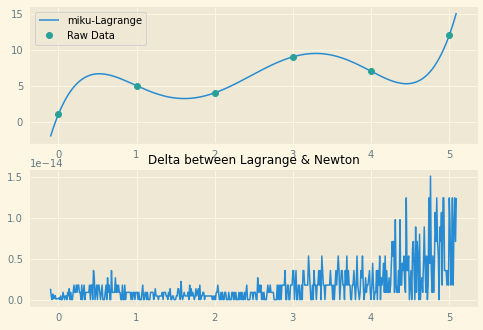

In [2]:
interpolation_samples = np.array([
    (0, 1),
    (1, 5),
    (2, 4),
    (3, 9),
    (4, 7),
    (5, 12)
    ])
interpolation_poly_lagrange = miku.heartland.orbitdance.poly_interpolate(interpolation_samples, "lagrange")
interpolation_poly_newton = miku.heartland.orbitdance.poly_interpolate(interpolation_samples, "newton")
with plt.rc_context({}):
    interpolation_x = np.arange(-.1, 5.1, .01)
    plt.subplot(211)
    interpolation_poly_lagrange.plot(interpolation_x, label="miku-Lagrange")
    plt.plot(interpolation_samples[ : , 0 ], interpolation_samples[ : , 1 ], "o", label="Raw Data")
    plt.legend()
    plt.subplot(212)
    plt.plot(
        interpolation_x,
        np.abs([
            interpolation_poly_lagrange(x) - interpolation_poly_newton(x)
            for x in interpolation_x
            ])
        )
    plt.title("Delta between Lagrange & Newton")
    plt.show()

# Datasets

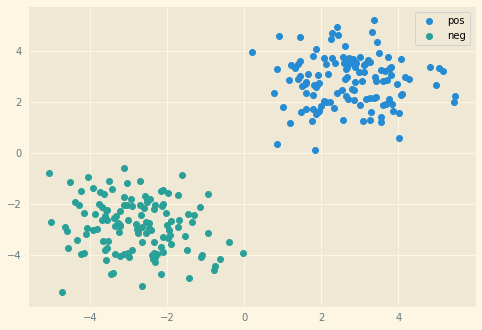

In [3]:
miku.datasets.psi.LBND().dataplot()
plt.legend()
plt.show()

# Fourier Series

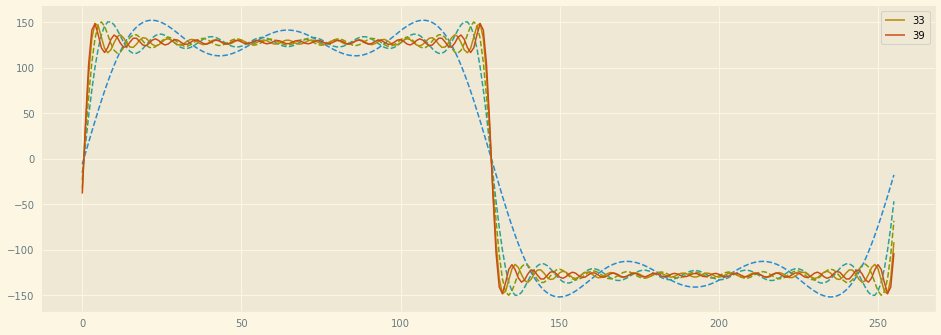

In [4]:
fseries_0 = miku.fourier.psi.Series([0] + [1] * 127 + [0] + [-1] * 127)
with plt.rc_context({"figure.figsize": [ 16, 5.6 ]}):
    for k in range(3):
        fseries_0.plotarray("--")
        fseries_0.append(9)
    fseries_0.plotarray("-", label=str(fseries_0.numiter))
    fseries_0.append(6)
    fseries_0.plotarray("-", label=str(fseries_0.numiter))
    plt.legend()
    plt.show()

# HMM (Hidden Markov Model)

In [5]:
traid_0 = miku.hmm.psi.HMM_Traid(
    A = np.array([
        [ 0., 1., 0., 0. ], # from the 1st Box
        [ .4, 0., .6, 0. ], # from the 2nd Box
        [ 0., .4, 0., .6 ], # from the 3rd Box
        [ 0., 0., .5, .5 ], # from the 4th Box
        ]),
    B = np.array([
        [ .5, .5 ], # from the 1st Box
        [ .3, .7 ], # from the 2nd Box
        [ .6, .4 ], # from the 3rd Box
        [ .8, .2 ], # from the 4th Box
        ]),
    pi = np.array([[ .25, .25, .25, .25 ]]),
    Q = ["Box1", "Box2", "Box3", "Box4"],
    V = ["Cyan", "Blue"],
    )
hmmtraid = miku.hmm.psi.HMM_Traid(
    A = np.array([
        [ .5, .2, .3 ],
        [ .3, .5, .2 ],
        [ .2, .3, .5 ],
        ]),
    B = np.array([
        [ .5, .5 ],
        [ .4, .6 ],
        [ .7, .3 ],
        ]),
    pi = np.array([[ .2, .4, .4 ]])
    )

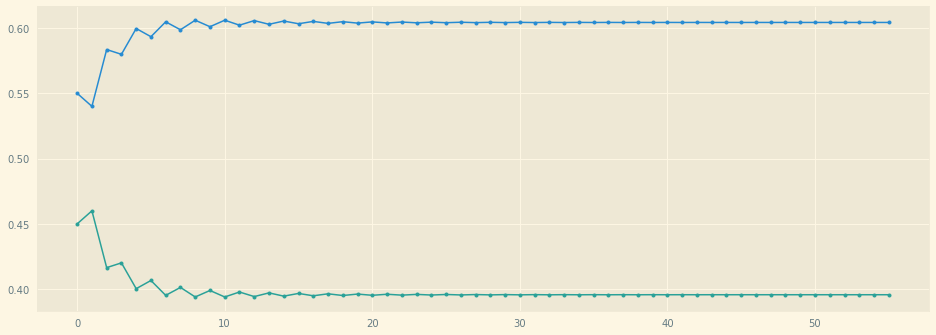

In [6]:
with plt.rc_context({"figure.figsize": [ 16, 5.6 ]}):
    plt.plot(traid_0.probseq_observe(56), ".-")
    plt.show()

## Backward

`HMM`计算观测序列概率的反向算法.

* **Backward Probability (反向概率)**: 给定隐马尔可夫模型 $ \lambda $, 定义在时刻 $ \tau $ 状态为 $ q_i $ 的条件下, 从 $ \tau + 1 $ 到`T`的部分观测序贯为 $ o_{\tau + 1}, o_{\tau + 2}, \cdots, o_T $ 的概率为后向概率, 记作:

  $$ \beta_{\tau}(i) = \Pr(o_{\tau + 1}, o_{\tau + 2}, \cdots, o_T | i_{\tau} = q_i, \lambda) $$

* **Backward Algorithm (反向算法)**

  * Input: HMM $ \lambda $, Observation Sequence (观测序贯) `O`;
  * Output: Probability of Observation Sequence (观测序贯概率) $ \Pr(O | \lambda) $;

  1. Initialization: $ \beta_T(i) = 1 $, where `i = 1, 2, ..., M`;

  2. For each $ \tau = T - 1, T - 2, \cdots, 1 $:

      $$ \begin{align*}
      \beta_{\tau}(i)
      &= \sum_{j=1}^M {a_{i, j} \cdot b_j(o_{\tau + 1}) \cdot \beta_{\tau + 1}(j)} \\
      &= \sum_{j=1}^M {a_{i, j} \cdot b_{j, o_{\tau + 1}} \cdot \beta_{\tau + 1}(j)} \\
      \end{align*} $$

      where `i = 1, 2, ..., M`;

  3. Finally, $ \Pr(O | \lambda) = \sum_{i=1}^M {\pi_i \cdot b_i(o_1) \cdot \beta_1(i)} = \sum_{i=1}^M {\pi_i \cdot b_{i, o_1} \cdot \beta_1(i)} $;

In [7]:
hmmtraid.prob_back([ 0, 1, 0 ])

0.130218

## Forward

* **Forward Probability**:

  $$ \alpha_{\tau}(i) = \Pr(o_1, o_2, \cdots, o_{\tau}, i_{\tau} = q_i | \lambda) $$

* **Forward Algorithm**:

  * Input: HMM $ \lambda $, Observation Sequence `O`;
  * Output: Probability of Observation Sequence $ \Pr(O | \lambda) $;

  1. Initialization: $ \alpha_1(i) = \pi_i \cdot b_i(o_1) = \pi_i \cdot b_{i, o_1} $, where `i = 1, 2, ..., M`;

  2. For each $ \tau = 1, 2, \cdots, T - 1 $,

    $$ \begin{align*}
    \alpha_{\tau + 1}(i)
    &= [ \sum_{j=1}^M {\alpha_{\tau}(j) \cdot a_{j, i}} ] b_i(o_{\tau + 1}) \\
    &= [ \sum_{j=1}^M {\alpha_{\tau}(j) \cdot a_{j, i}} ] b_{i, o_{\tau + 1}} \\
    \end{align*} $$

    where `i = 1, 2, ..., M`;

  3. Finally, $ \Pr(O | \lambda) = \sum_{i=1}^M {\alpha_T(i)} $;

In [8]:
hmmtraid.prob_fore([ 0, 1, 0 ])

0.130218

## `Prediction`: Viterbi

In [9]:
hmmtraid.predict([ 0, 1, 0 ])

([2, 2, 2], 0.014699999999999998)

## `Fitting`: Baum Welch

In [10]:
hmmtraid.fit_seq([ 0, 1, 0 ])

<Hidden_Markov_Model λ = (A, B, π)
Transition Mat A:
[[0.49553639 0.18217582 0.32228779]
 [0.30734633 0.47476262 0.21789105]
 [0.21546725 0.32521516 0.45931759]]
Emission Mat B:
[[0.60833435 0.39166565]
 [0.5809173  0.4190827 ]
 [0.7836312  0.2163688 ]]
Initial Prob π:
[[0.18539644 0.31876207 0.49584149]]
@ 0x7fb1787b2b50>

In [11]:
miku.hmm.psi.new_hmm(hmmtraid.shape).fit_seq([ 0, 1, 0 ])

<Hidden_Markov_Model λ = (A, B, π)
Transition Mat A:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Emission Mat B:
[[0.66666667 0.33333333]
 [0.66666667 0.33333333]
 [0.66666667 0.33333333]]
Initial Prob π:
[[0.33333333 0.33333333 0.33333333]]
@ 0x7fb1557304f0>

In [12]:
miku.hmm.phi.new_hmm(hmmtraid.shape).fit_seq([ 0, 1, 0 ])

<Hidden_Markov_Model λ = (A, B, π)
Transition Mat A:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Emission Mat B:
[[0.66666667 0.66666667 0.66666667]
 [0.33333333 0.33333333 0.33333333]]
Initial Prob π:
[[0.33333333]
 [0.33333333]
 [0.33333333]]
@ 0x7fb155730bb0>

# More...